In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import re
from datetime import datetime

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import yaml
from Bio import SeqIO
from datasets import Dataset, DatasetDict, load_from_disk
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, recall_score
from torch.utils.data import DataLoader
from transformers import (
    DataCollatorWithPadding,
    PretrainedConfig,
    PreTrainedModel,
    T5EncoderModel,
    T5Tokenizer,
    Trainer,
    TrainingArguments,
    modeling_outputs,
)
from transformers.utils import (
    is_datasets_available,
)
from src.model.localization import LightAttentionPLM, LightAttentionCLIP, LinearPLM, LinearCLIP

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Matplotlib created a temporary cache directory at /tmp/matplotlib-og8fymi2 because the default path (/home/lfi/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
train_config = {
    "project_name": "light_attention_localization",
    "run_name": "no_backprop_no_lora_LA_protT5",
    "seed": 42,
    "weights_and_biases": {
        "enabled": True,
        "project_name": "light_attention_localization",
        "report_to": "wandb",
    },
    "model": {
        "plm": "Rostlab/prot_t5_xl_uniref50",
        
        "freeze_plm": True,
    },
    "light_attention": {
        "dropout": 0.25,
        "kernel_size": 9,
        "output_dim": 10,
    },
    "linear_classifier": {
        "dropout": 0.25,
        "output_dim": 10,
    },
    "lora": {
        "enabled": False,
        "r": 8,
        "lora_alpha": 16,
        "lora_dropout": 0.05,
        "use_rslora": False,
        "use_dora": False,
        "target_modules": [],
        "modules_to_save": [],
    },
    "trainer": {
        "learning_rate": 1e-4,
        "train_batch_size": 64,
        "num_epochs": 1,
        "eval_batch_size": 32,
        "eval_strategy": "steps",
        "eval_steps": 64,
        "eval_on_start": True,
        "eval_sample_size": 32,
        "batch_eval_metrics": True,
        "remove_unused_columns": False,
        "save_strategy": "no",
        "save_steps": 300,
        "save_total_limit": 5,
        "logging_steps": 1,
        "lr_scheduler_type": "cosine",
        "warmup_steps": 100,
    },
}

model_name_identifier = train_config["project_name"] + "-" + train_config["run_name"] + "-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

label2location = {
    "Cell.membrane": 0,
    "Cytoplasm": 1,
    "Endoplasmic.reticulum": 2,
    "Extracellular": 3,
    "Golgi.apparatus": 4,
    "Lysosome/Vacuole": 5,
    "Mitochondrion": 6,
    "Nucleus": 7,
    "Peroxisome": 8,
    "Plastid": 9,
}

location2label = {
    0: "Cell.membrane",
    1: "Cytoplasm",
    2: "Endoplasmic.reticulum",
    3: "Extracellular",
    4: "Golgi.apparatus",
    5: "Lysosome/Vacuole",
    6: "Mitochondrion",
    7: "Nucleus",
    8: "Peroxisome",
    9: "Plastid",
}

print(model_name_identifier)

light_attention_localization-2025-01-23-10-37-58


In [3]:
if train_config["weights_and_biases"]["enabled"]:
    import wandb
    run = wandb.init(project=train_config["weights_and_biases"]["project_name"], name=model_name_identifier)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
2025/01/23 10:38:01 INFO server is running addr=127.0.0.1:33781
2025/01/23 10:38:01 INFO Will exit if parent process dies. ppid=32601
2025/01/23 10:38:01 INFO connection: ManageConnectionData: new connection created id=127.0.0.1:45144
wandb: Currently logged in as: finnlueth (finnlueth-organization). Use `wandb login --relogin` to force relogin
2025/01/23 10:38:01 INFO handleInformInit: received streamId=zeok7n72 id=127.0.0.1:45144
2025/01/23 10:38:01 INFO handleInformInit: stream started streamId=zeok7n72 id=127.0.0.1:45144


In [4]:
tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path="Rostlab/prot_t5_xl_uniref50",
    do_lower_case=False,
    use_fast=True,
    legacy=False,
)

if not os.path.exists("../tmp/data/unprocessed/localization/deeploc_data_processed"):
    train_sequences = []
    train_ids = []
    train_labels = []
    with open("../tmp/data/unprocessed/localization/deeploc_data.fasta", "r") as f:
        for record in SeqIO.parse(f, "fasta"):
            train_sequences.append(str(record.seq))
            desc_parts = record.description.split()
            train_ids.append(desc_parts[0])
            train_labels.append(desc_parts[1].split("-")[0])

    test_sequences = []
    test_ids = []
    test_labels = []
    with open("../tmp/data/unprocessed/localization/new_hard_test_set_PIDE20.fasta_rep_seq.fasta", "r") as f:
        for record in SeqIO.parse(f, "fasta"):
            test_sequences.append(str(record.seq))
            desc_parts = record.description.split()
            test_ids.append(desc_parts[0])
            test_labels.append(desc_parts[1].split("-")[0])

    train_dataset = Dataset.from_dict({"sequence": train_sequences, "id": train_ids, "location": train_labels})

    test_dataset = Dataset.from_dict({"sequence": test_sequences, "id": test_ids, "location": test_labels})

    dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

    def process_sequences(sequences):
        processed_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", seq))) for seq in sequences]
        return processed_sequences

    train_processed = process_sequences(dataset["train"]["sequence"])
    test_processed = process_sequences(dataset["test"]["sequence"])

    train_encodings = tokenizer(train_processed, padding=False, truncation=False)

    test_encodings = tokenizer(test_processed, padding=False, truncation=False)

    dataset["train"] = dataset["train"].add_column("processed_sequence", train_processed)
    dataset["train"] = dataset["train"].add_column("input_ids", train_encodings["input_ids"])
    dataset["train"] = dataset["train"].add_column("attention_mask", train_encodings["attention_mask"])

    dataset["test"] = dataset["test"].add_column("processed_sequence", test_processed)
    dataset["test"] = dataset["test"].add_column("input_ids", test_encodings["input_ids"])
    dataset["test"] = dataset["test"].add_column("attention_mask", test_encodings["attention_mask"])

    dataset["train"] = dataset["train"].map(lambda x: {"labels": label2location[x["location"]]})
    dataset["test"] = dataset["test"].map(lambda x: {"labels": label2location[x["location"]]})

    dataset.save_to_disk("../tmp/data/unprocessed/localization/deeploc_data_processed")
else:
    dataset = load_from_disk("../tmp/data/unprocessed/localization/deeploc_data_processed")


print(f"Dataset size in MB: {sum(dataset[split].data.nbytes for split in dataset) / (1024 * 1024):.2f}")
print(dataset)
print(dataset["train"][0])
print(dataset["test"][0])

Dataset size in MB: 138.13
DatasetDict({
    train: Dataset({
        features: ['sequence', 'id', 'location', 'processed_sequence', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14004
    })
    test: Dataset({
        features: ['sequence', 'id', 'location', 'processed_sequence', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 490
    })
})
{'sequence': 'MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGSATAAEASLLRRTHLCSLSKSDTRLHELHRGPRSSRALRPASMDLLRPHWLEVSRDITGPQAAPSAFPHQELPRALPAAAATAGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPAGRSSTCGAGTPPASSCPSLGRGWRPLPASLP', 'id': 'Q9H400', 'location': 'Cell.membrane', 'processed_sequence': 'M G L P V S W A P P A L W V L G C C A L L L S L W A L C T A C R R P E D A V A P R K R A R R Q R A R L Q G S A T A A E A S L L R R T H L C S L S K S D T R L H E L H R G P R S S R A L R P A S M D L L R P H W L E V S R D I T G P Q A A P S A F P H Q E L

Longest sequence in train set: 13100
Longest sequence in test set: 5495
Longest sequence overall: 13100

Example of longest sequence (from train set):
MGGRNWLFRSAVLVSTLLTCISIAQELLPSIEVESLAQDLQIQEWMRTLRRVKRAPTRNNRPEPVVVGRNGTGKCVISADRASHFCGMEEEVSAPPIPPPDEGKCIISKASGREICYPSYSQLDTSCTDVTGQSSNGLVVPPVVPHATVRAMAFVPPDNLRRLIIQYYRQQGKHQPKNATFSPKSFLFVKYHCDYGYEMVDEVDTMFCQDKKWVMTPPMCRGQGLCAADNGGCSHTCISYNDEKIECKCPRGMTLDVDEKTCIKPIPKSLCRSLSGCTCNGITETQFACSCGDNKQKCLLIAGPPRIYIEPQGPYEVAPGGNINISCTSVAYPFPDIYWFKNQKVNTDGPDQNTLRASQILIIKEIYRNEEFTCVSDNIHGSANRTVSIVVTGPGSAPHLKSASAGRTSLTVRWEPPSIINRPITTYTLYYTNNPQQPVKNWKKLEVKEPTREVAIPDLRPDTAYYIRVRANDPLGPGKLGNQVQIKTLKPAVRPYVNIVEGDEIRVPPMTAFEIDCNVTRADPVPVLVWLHKGRPLNKGSKTQHIKMKNGGVLESTQFSCVAENEAGKSTKKINVTVTGPSAPERIRYQIDGDKVTLQWEPPQITNGPMAGYDVFYTEDPSLPRDQWKVHHIDDPNARTTTVLRLNEKTPYTFVIVGRNRLGPGLPSAPFTATTWLAAKPPVVQLEPSEEMTKEPSNDEMIIECGAQGVPKPKIIWLWSGTLIEDGKEEFRVYDTTPTDAQDRTRSKLIAQSTTRSGVATCQAVNSEGSDEKKVPVKILGPGSAPLGITPTPMHTGFDVAWKPPKVTNGRITDYVVYYSKDPDAPLSDWESKTVPADTRNLTVNVDDE

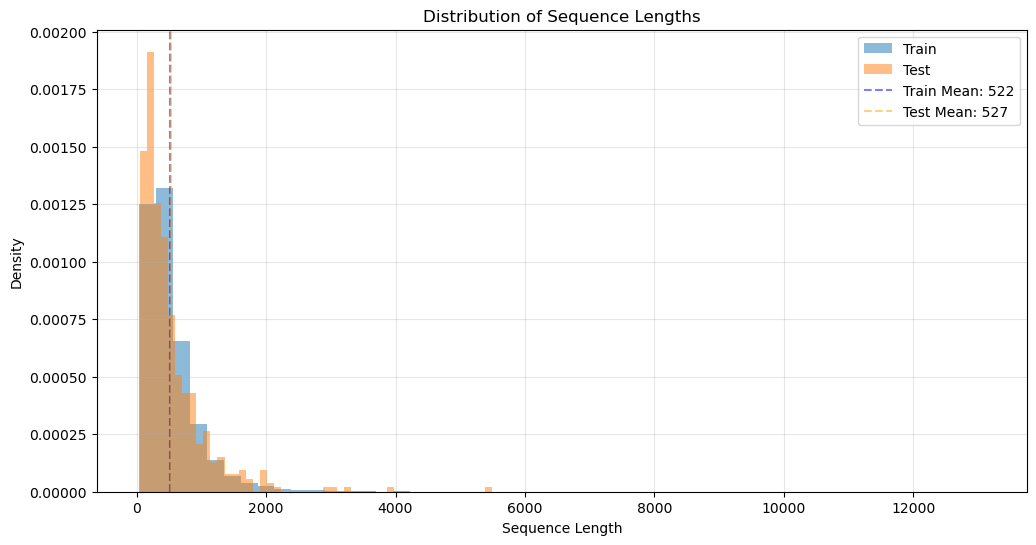


Sequence length statistics:
Train set - Mean: 522.4, Median: 421
Test set  - Mean: 526.7, Median: 368


In [5]:
train_lengths = [len(seq) for seq in dataset["train"]["sequence"]]
test_lengths = [len(seq) for seq in dataset["test"]["sequence"]]

max_train_length = max(train_lengths)
max_test_length = max(test_lengths)
max_length = max(max_train_length, max_test_length)

print(f"Longest sequence in train set: {max_train_length}")
print(f"Longest sequence in test set: {max_test_length}")
print(f"Longest sequence overall: {max_length}")

longest_idx = train_lengths.index(max_train_length) if max_train_length == max_length else test_lengths.index(max_test_length)
longest_split = "train" if max_train_length == max_length else "test"
print(f"\nExample of longest sequence (from {longest_split} set):")
print(dataset[longest_split][longest_idx]["sequence"])

plt.figure(figsize=(12, 6))

plt.hist(train_lengths, bins=50, alpha=0.5, label="Train", density=True)
plt.hist(test_lengths, bins=50, alpha=0.5, label="Test", density=True)

plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.title("Distribution of Sequence Lengths")
plt.legend()
plt.grid(True, alpha=0.3)

plt.axvline(
    sum(train_lengths) / len(train_lengths),
    color="blue",
    linestyle="dashed",
    alpha=0.5,
    label=f"Train Mean: {sum(train_lengths)/len(train_lengths):.0f}",
)
plt.axvline(
    sum(test_lengths) / len(test_lengths),
    color="orange",
    linestyle="dashed",
    alpha=0.5,
    label=f"Test Mean: {sum(test_lengths)/len(test_lengths):.0f}",
)

plt.legend()
plt.show()

print(f"\nSequence length statistics:")
print(f"Train set - Mean: {sum(train_lengths)/len(train_lengths):.1f}, Median: {sorted(train_lengths)[len(train_lengths)//2]}")
print(f"Test set  - Mean: {sum(test_lengths)/len(test_lengths):.1f}, Median: {sorted(test_lengths)[len(test_lengths)//2]}")


In [6]:
max_allowed_length = 1024

train_indices = [i for i, length in enumerate(train_lengths) if length <= max_allowed_length]
dataset["train"] = dataset["train"].select(train_indices)

test_indices = [i for i, length in enumerate(test_lengths) if length <= max_allowed_length]
dataset["test"] = dataset["test"].select(test_indices)

print(f"Filtered dataset statistics:")
print(f"Train set: {len(dataset['train'])} sequences (removed {len(train_lengths) - len(dataset['train'])} sequences)")
print(f"Test set: {len(dataset['test'])} sequences (removed {len(test_lengths) - len(dataset['test'])} sequences)")

Filtered dataset statistics:
Train set: 12704 sequences (removed 1300 sequences)
Test set: 432 sequences (removed 58 sequences)


In [7]:
example_sequence = dataset["train"][0]["input_ids"]
decoded_sequence = tokenizer.decode(example_sequence)
print("Original sequence:\t\t", dataset["train"][0]["sequence"])
print("Tokenized and decoded sequence:\t", decoded_sequence.replace(" ", ""))

Original sequence:		 MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGSATAAEASLLRRTHLCSLSKSDTRLHELHRGPRSSRALRPASMDLLRPHWLEVSRDITGPQAAPSAFPHQELPRALPAAAATAGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPAGRSSTCGAGTPPASSCPSLGRGWRPLPASLP
Tokenized and decoded sequence:	 MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGSATAAEASLLRRTHLCSLSKSDTRLHELHRGPRSSRALRPASMDLLRPHWLEVSRDITGPQAAPSAFPHQELPRALPAAAATAGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPAGRSSTCGAGTPPASSCPSLGRGWRPLPASLP</s>


In [8]:
# print("\nTrain set label distribution:")
# print(pd.Series(dataset["train"]["label"]).value_counts())

# print("\nTest set label distribution:")
# print(pd.Series(dataset["test"]["label"]).value_counts())

# print("\nNumber of distinct labels:")
# print(f"Train: {len(set(dataset['train']['label']))}")
# print(f"Test: {len(set(dataset['test']['label']))}")


# unique_labels = sorted(set(dataset["train"]["location"]).union(set(dataset["test"]["location"])))
# label2id = {label: idx for idx, label in enumerate(unique_labels)}
# id2label = {idx: label for label, idx in label2id.items()}

# print(label2id)
# print(id2label)

In [25]:
config = PretrainedConfig(
    plm=train_config["model"]["plm"],
    output_hidden_states=True,
    output_attentions=True,
    return_dict=True,
    device=device,
    freeze_plm=train_config["model"]["freeze_plm"],
    light_attention=train_config["light_attention"],
    num_labels=len(label2location),
    # classifier_dropout=train_config["trainer"]["classifier_dropout"],
)

config.num_labels

10

In [ ]:
model = LightAttentionPLM(config)
model = model.to(device)

if train_config["model"]["freeze_plm"]:
    for param in model.plm.parameters():
        param.requires_grad = False

if train_config["lora"]["enabled"]:
    from peft import LoraConfig, get_peft_model

    lora_config = LoraConfig(
        inference_mode=False,
        r=train_config["lora"]["r"],
        lora_alpha=train_config["lora"]["lora_alpha"],
        lora_dropout=train_config["lora"]["lora_dropout"],
        target_modules=train_config["lora"]["target_modules"],
        bias="none",
        modules_to_save=train_config["lora"]["modules_to_save"],
        use_rslora=train_config["lora"]["use_rslora"],
        use_dora=train_config["lora"]["use_dora"],
    )

    model = get_peft_model(model, lora_config)
    print("target_modules:", lora_config.target_modules)
    print("modules_to_save:", lora_config.modules_to_save)

model.print_trainable_parameters()

for name, param in model.named_parameters():
    if not param.is_cuda:
        print(f"Warning: Parameter {name} is not on CUDA")

In [11]:
# model.eval()

# split = "test"

# random_idx = random.randint(0, len(dataset[split]))
# with torch.no_grad():
#     out = model(
#         input_ids=torch.tensor([dataset[split][random_idx]["input_ids"]]).to(device),
#         attention_mask=torch.tensor([dataset[split][random_idx]["attention_mask"]]).to(device),
#         labels=torch.tensor([label2location[dataset[split][random_idx]["location"]]]).to(device),
#     )
    
# print(dataset[split][random_idx]["location"])
# print(dataset[split][random_idx]["sequence"])
# print()
# print(out.logits.shape)
# print(out.logits.softmax(dim=-1))
# print(out.logits.argmax(dim=-1))

In [ ]:
training_args = TrainingArguments(
    output_dir=f"../tmp/models/checkpoints/{train_config['project_name']}",
    run_name=train_config["project_name"] if train_config["weights_and_biases"]["enabled"] else None,
    report_to=train_config["weights_and_biases"]["report_to"] if train_config["weights_and_biases"]["enabled"] else None,
    learning_rate=train_config["trainer"]["learning_rate"],
    per_device_train_batch_size=train_config["trainer"]["train_batch_size"],
    num_train_epochs=train_config["trainer"]["num_epochs"],
    eval_strategy=train_config["trainer"]["eval_strategy"],
    eval_on_start=True,
    eval_steps=train_config["trainer"]["eval_steps"],
    per_device_eval_batch_size=train_config["trainer"]["eval_batch_size"],
    save_strategy=train_config["trainer"]["save_strategy"],
    save_steps=train_config["trainer"]["save_steps"],
    save_total_limit=train_config["trainer"]["save_total_limit"],
    logging_strategy="steps",
    logging_steps=train_config["trainer"]["logging_steps"],
    seed=train_config["seed"],
    lr_scheduler_type=train_config["trainer"]["lr_scheduler_type"],
    warmup_steps=train_config["trainer"]["warmup_steps"],
    label_names=["labels"],
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, pad_to_multiple_of=8)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    print(predictions)
    print(labels)
    
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "mcc": matthews_corrcoef(labels, predictions),
    }


trainer = LightAttentionTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["train"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    eval_sample_size=train_config["trainer"]["eval_sample_size"],
)

In [ ]:
# trainer.train()
trainer.evaluate()

In [ ]:
for name, param in model.light_attention.named_parameters():
    print(name)

In [ ]:
model_save_path = f"../tmp/models/{model_name_identifier}"

if train_config["lora"]["enabled"]:
    model.save_pretrained(
        save_directory=model_save_path
    )
else:
    if type(model.light_attention) == 
    state_dict = 
    model.save_pretrained(
        save_directory=model_save_path,
        state_dict=state_dict,
    )

In [ ]:
history = pd.DataFrame(trainer.state.log_history)
history.to_csv(f"{model_save_path}/training_log.csv", index=False)

with open(f"{model_save_path}/train_config.yaml", "w") as f:
    train_config["model"]["reload_from_checkpoint_path"] = model_save_path
    yaml.dump(train_config, f, sort_keys=False)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

metrics = ['eval_accuracy', 'eval_f1', 'eval_recall', 'eval_mcc']
for metric in metrics:
    ax1.plot(history[history[metric].notna()]['step'], 
             history[history[metric].notna()][metric],
             marker='o', label=metric.replace('eval_', ''))
ax1.set_xlabel('Step')
ax1.set_ylabel('Score')
ax1.set_title('Evaluation Metrics')
ax1.legend()
ax1.grid(True)

train_loss = history[history['loss'].notna()]
eval_loss = history[history['eval_loss'].notna()]
ax2.plot(train_loss['step'], train_loss['loss'], 
         label='Training Loss', marker='o')
ax2.plot(eval_loss['step'], eval_loss['eval_loss'],
         label='Evaluation Loss', marker='o')
ax2.set_xlabel('Step')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Evaluation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()


fig.savefig(f"{model_save_path}/training_history.png")
plt.close(fig)

print("Model, config, and log saved to:", model_save_path)